# Sentiment Analysis using LSTM, ML and NLP

# Importing necessary libraries

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report,plot_confusion_matrix
import seaborn as sns

# Dataset Cleaning

In [2]:
data_path="./Tweets.csv"
df = pd.read_csv(data_path) # Reading csv file
# Checking all columns of dataset
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [3]:
# Extracting 2 columns "text" & "airline_sentiment"
reviews_df = df[['text','airline_sentiment']]
print(reviews_df.shape)
reviews_df.head(5)

(14640, 2)


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [4]:
# Removing any neutral sentiments
reviews_df = reviews_df[reviews_df['airline_sentiment'] != 'neutral']

print(reviews_df.shape)
reviews_df.head(5)

(11541, 2)


,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive


In [5]:
# Checking total positive and negative sentiment count
reviews_df["airline_sentiment"].value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

# Dataset Preprocessing

In [6]:
# Encode the 'airline_sentiment' column as integers
sentiment_encoding = reviews_df.airline_sentiment.factorize()

sentiment_encoding

(array([0, 1, 1, ..., 0, 1, 1], dtype=int64),
 Index(['positive', 'negative'], dtype='object'))

In [7]:
# Extracting text data from text column and assigning to tweet variable
tweet = reviews_df.text.values

# Create a Tokenizer object with a vocabulary size of 5000
tokenizer = Tokenizer(num_words=5000)

# Fit the tokenizer on the tweet data.
tokenizer.fit_on_texts(tweet)

# Encode the tweet data using the fitted tokenizer
encoded_tweets = tokenizer.texts_to_sequences(tweet)

# Use padding to pad the sentences to have equal length
padded_sequence = pad_sequences(encoded_tweets, maxlen=200)

# Build Text Classifier using LSTM Model

In [8]:
# Calculate the vocabulary size by adding 1 to the length of the word index
vocab_size = len(tokenizer.word_index) + 1

# Set the length of the embedding vector to 32
embedding_vector_length = 32

# Create a Sequential model.
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with binary crossentropy loss and Adam optimization, and track accuracy
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

# Print a summary of the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           423488    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 440,139
Trainable params: 440,139
Non-trainable params: 0
__________________________________________________

# Train test split model training

In [9]:
# Split the data and labels into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_sequence, sentiment_encoding[0], test_size=0.2)

# Train the model on the training set
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)

Epoch 1/5
289/289 [==============================] - 35s 109ms/step - loss: 0.3786 - accuracy: 0.8473 - val_loss: 0.2593 - val_accuracy: 0.8917
Epoch 2/5
289/289 [==============================] - 32s 109ms/step - loss: 0.2100 - accuracy: 0.9196 - val_loss: 0.2097 - val_accuracy: 0.9177
Epoch 3/5
289/289 [==============================] - 31s 108ms/step - loss: 0.1539 - accuracy: 0.9420 - val_loss: 0.2025 - val_accuracy: 0.9255
Epoch 4/5
289/289 [==============================] - 31s 109ms/step - loss: 0.1290 - accuracy: 0.9520 - val_loss: 0.2146 - val_accuracy: 0.9264
Epoch 5/5
289/289 [==============================] - 32s 111ms/step - loss: 0.1115 - accuracy: 0.9596 - val_loss: 0.2068 - val_accuracy: 0.9307


# Performance metrics

In [10]:
# Obtain the predictions for the validation set
predictions = model.predict(X_val)

# Convert the predictions to class labels (0 or 1)
predictions = (predictions > 0.5).astype(int)


# Generate a classification report
report = classification_report(y_val, predictions)
print("Classification report:")
print(report)

73/73 [==============================] - 2s 18ms/step
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.76      0.82       476
           1       0.94      0.97      0.96      1833

    accuracy                           0.93      2309
   macro avg       0.91      0.87      0.89      2309
weighted avg       0.93      0.93      0.93      2309



#  Confusion Matrix

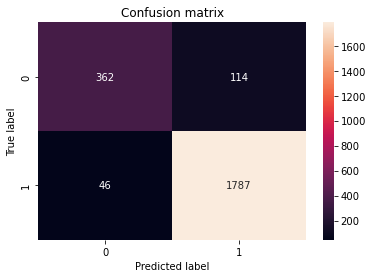

In [11]:
# Visualizing confusion matrix
confusion_matrix = confusion_matrix(y_val, predictions)

sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

# Learning Curve 

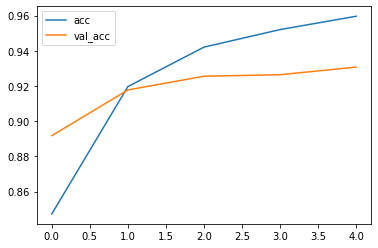

<Figure size 432x288 with 0 Axes>

In [12]:
# Plot the training and validation accuracy over the training epochs
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')

# Adding legend to the plot
plt.legend()

# Displaying plot
plt.show()

# Save the plot as an image file
plt.savefig("Accuracy plot.jpg")

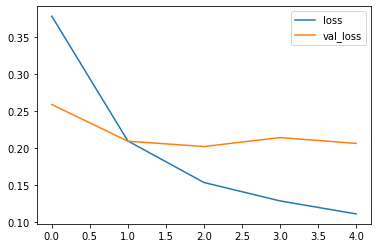

<Figure size 432x288 with 0 Axes>

In [13]:
# Plot the training and validation loss over the training epochs
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

# Adding legend to the plot
plt.legend()

# Displying plot
plt.show()

# Save the plot as an image file
plt.savefig("Loss plt.jpg")

# Analaysis output

In [14]:
# Function for performing sentiment analysis on a given piece of text
def sentiment_analysis(text):
    # Encode the text into a sequence of integers using the tokenizer
    tw = tokenizer.texts_to_sequences([text])
    
    # Padding the encoded sequence to a fixed length
    tw = pad_sequences(tw,maxlen=200)
    
    # Using the model to make a prediction on the padded sequence
    prediction = int(model.predict(tw).round().item())
    
    # Print the predicted label using the encoded sentiment labels
    print("Predicted label: ", sentiment_encoding[1][prediction])

# Continuously prompt the user to enter a text to analyze
while True:
    text = input("Enter a text to analyze (or 'q' to quit): ")
    
    # If the user enters 'q', break out of the loop
    if text == 'q':
        break
    
    # Otherwise, call the sentiment_analysis function on the entered text
    sentiment_analysis(text)

Enter a text to analyze (or 'q' to quit): The flight was very pleasant.
1/1 [==============================] - 0s 28ms/step
Predicted label:  positive
Enter a text to analyze (or 'q' to quit): The flight was unpleasant.
1/1 [==============================] - 0s 26ms/step
Predicted label:  negative
Enter a text to analyze (or 'q' to quit): The flight did have some bad turbulence but the overall experience was very good
1/1 [==============================] - 0s 28ms/step
Predicted label:  negative
Enter a text to analyze (or 'q' to quit): The product works well
1/1 [==============================] - 0s 27ms/step
Predicted label:  positive
Enter a text to analyze (or 'q' to quit): She was a lifesaver, she helped me a lot
1/1 [==============================] - 0s 27ms/step
Predicted label:  positive
Enter a text to analyze (or 'q' to quit): The product was not as expected
1/1 [==============================] - 0s 28ms/step
Predicted label:  negative
Enter a text to analyze (or 'q' to quit)

# Bar chart and Pie chart

In [34]:
check_data="./Tweets.csv"
airline_df = pd.read_csv(check_data) # Reading csv file
airline_df = airline_df[airline_df['airline_sentiment'] != 'neutral']
sentence_column=airline_df.columns[10]
# Extracting text data from text column and assigning to tweet variable
new_tweet = airline_df[sentence_column].values

# Create a Tokenizer object with a vocabulary size of 5000
tokenizer = Tokenizer(num_words=5000)

# Fit the tokenizer on the tweet data.
tokenizer.fit_on_texts(new_tweet)

# Encode the tweet data using the fitted tokenizer
encoded_tweets = tokenizer.texts_to_sequences(new_tweet)

# Use padding to pad the sentences to have equal length
padded_sequence = pad_sequences(encoded_tweets, maxlen=200)
predictions = model.predict(padded_sequence).round()
prediction_list = predictions.tolist()


361/361 [==============================] - 6s 17ms/step


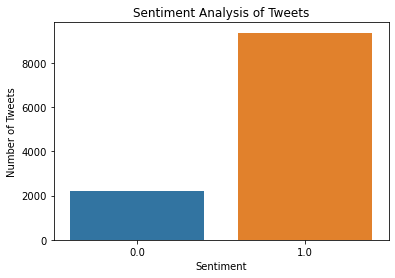

In [35]:
#create a dataframe for the predictions
df_predictions = pd.DataFrame(prediction_list, columns=['sentiment'])
#create a countplot for the sentiment column in the dataframe
sns.countplot(x='sentiment', data=df_predictions)
#add x and y labels and title for the chart
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.title("Sentiment Analysis of Tweets")
#show the chart
plt.show()

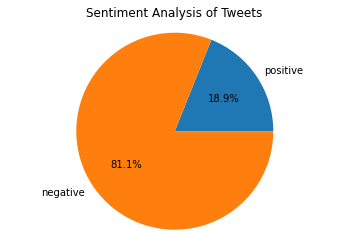

In [36]:
#count the number of occurrences of each sentiment label in the dataframe
sentiment_counts = df_predictions['sentiment'].value_counts()

# create the labels for the pie chart
labels = ['positive', 'negative']
#create the size of each section based on the sentiment counts
sizes = [sentiment_counts[0], sentiment_counts[1]]

# create the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
# make the pie chart circular
plt.axis('equal')
# add a title to the chart
plt.title("Sentiment Analysis of Tweets")
# show the chart
plt.show()